In [111]:
import boto3
import json
import datetime
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick

CANSERVER_PARSED_BUCKET = 'matt3r-canserver-us-west-2'
CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

In [87]:
start_date_str = '2023-04-01'
end_date_str = '2023-04-01'
organization_id = 'amirm'
imu_k3y_id = '47d72c45'

# start_date_str = '2023-05-31'
# end_date_str = '2023-05-31'
# organization_id = 'hamid'
# imu_k3y_id = '78f8031e'

start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

Retrieve the raw IMU data

In [88]:
# retrieve the IMU data
if organization_id == 'amirm': usb = 'usb' 
else: usb = '' 

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects_v2(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y' + usb + '-' + imu_k3y_id + '/accel/')
all_keys = [item['Key'] for item in response.get('Contents', [])]
while response['IsTruncated']:
    response = s3_client.list_objects_v2(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y' + usb + '-' + imu_k3y_id + '/accel/', ContinuationToken=response['NextContinuationToken'])
    all_keys.extend([item['Key'] for item in response.get('Contents', [])])
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and file.split('/')[-1].split('_')[0] == 'raw'
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[1], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[1], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    imu_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(imu_df)
imu_df = pd.concat(df_list, axis=0, ignore_index=True)

print(imu_df)

         timestamp(epoch in sec)  lr_acc(m/s^2)  bf_acc(m/s^2)   
0                   1.680304e+09       9.870588       0.176410  \
1                   1.680304e+09       9.873578       0.182988   
2                   1.680304e+09       9.871186       0.175214   
3                   1.680304e+09       9.871784       0.181792   
4                   1.680304e+09       9.874176       0.176410   
...                          ...            ...            ...   
2384403             1.680390e+09       9.899890      -0.093886   
2384404             1.680390e+09       9.904076      -0.093886   
2384405             1.680390e+09       9.905870      -0.092690   
2384406             1.680390e+09       9.910056      -0.080730   
2384407             1.680390e+09       9.903478      -0.080132   

         vert_acc(m/s^2)  
0              -0.699062  
1              -0.696072  
2              -0.697866  
3              -0.700258  
4              -0.705640  
...                  ...  
2384403        -0.

Filter for Only Stationary States

In [94]:
start_time = 20000 + 1.6803 * 10**9
end_time = 60000 + 1.6803 * 10**9
ss_df = imu_df[(imu_df['timestamp(epoch in sec)'] > start_time) & (imu_df['timestamp(epoch in sec)'] < end_time)]

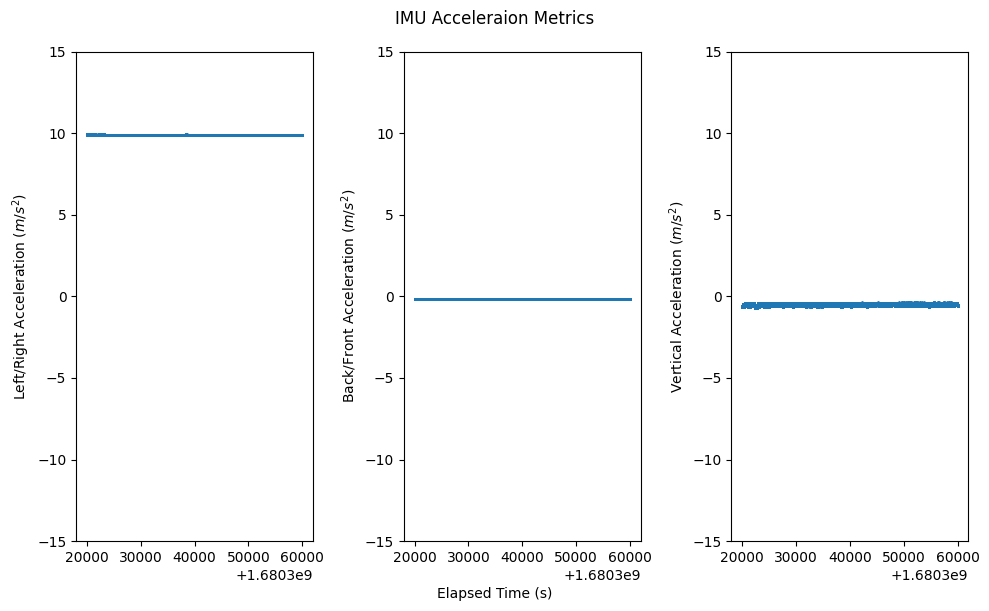

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(10,6)

ax1.scatter(x=ss_df['timestamp(epoch in sec)'], y=ss_df['lr_acc(m/s^2)'], s=1, label='IMU')
ax1.set_ylim(-15,15)

ax2.scatter(x=ss_df['timestamp(epoch in sec)'], y=ss_df['bf_acc(m/s^2)'], s=1, label='IMU')
ax2.set_ylim(-15,15)

ax3.scatter(x=ss_df['timestamp(epoch in sec)'], y=ss_df['vert_acc(m/s^2)'], s=1, label='IMU')
ax3.set_ylim(-15,15)

fig.suptitle("IMU Acceleraion Metrics")
fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

plt.tight_layout()
plt.show()

Compute the Rotation Matrix

In [107]:
# compute the acceleration direction

lr = ss_df['lr_acc(m/s^2)'].mean()
bf = ss_df['bf_acc(m/s^2)'].mean()
vert = ss_df['vert_acc(m/s^2)'].mean()

acc = np.array([lr, bf, vert])
print(acc)

[ 9.89606019 -0.1648591  -0.43540528]


In [108]:
def rotateAlign(v1, v2):
    axis = np.cross(v1, v2)
    cosA = np.dot(v1, v2)
    k = 1 / (1 + cosA)
    result = np.array( [[(axis[0] * axis[0] * k) + cosA,
            (axis[1] * axis[0] * k) - axis[2], 
            (axis[2] * axis[0] * k) + axis[1]],
            [(axis[0] * axis[1] * k) + axis[2],  
            (axis[1] * axis[1] * k) + cosA,      
            (axis[2] * axis[1] * k) - axis[0]],
            [(axis[0] * axis[2] * k) - axis[1],  
            (axis[1] * axis[2] * k) + axis[0],  
            (axis[2] * axis[2] * k) + cosA]])
    return result

In [109]:
def getRotMatrix(acc):
    acc_dir = acc/np.linalg.norm(acc)
    return rotateAlign(acc_dir,np.array([0,0,1]))

rotMat = getRotMatrix(acc)
print(acc)
print(rotMat)

[ 9.89606019 -0.1648591  -0.43540528]
[[-0.04365959  0.01738639 -0.99889517]
 [ 0.01738639  0.99971036  0.01664066]
 [ 0.99889517 -0.01664066 -0.04394923]]


Verify Gravity Compensation

In [113]:
k3y_g = 9.81
S3_K3Y_VEH_ROT_MTX = rotMat

def calculate_rot_matrix(ac_data, gy_data, filter_params):
    madg_filter = Madgwick(acc=ac_data, gyr=gy_data, Dt=(1/filter_params['SR']), gain=filter_params['gain'],
                        q0=filter_params['init_qua'])
    quaternions = madg_filter.Q
    filter_params['init_qua'] = quaternions[-1,:]
    # converting quaternion from scalar first (AHRS library) to scalar last(SciPy)
    quaternions_scipy = np.roll(quaternions, shift=3, axis=1)
    rot_mtxs = R.from_quat(quaternions_scipy).as_matrix()

    return rot_mtxs

def gravity_compensate(ac_batch, gy_batch, madgwick_params, g=k3y_g):
    rotation_mtxs = calculate_rot_matrix(ac_batch, gy_batch, madgwick_params)
    # Rotation matrix is orthogonal, last colum = last row of the inverse
    gravity_components = g * rotation_mtxs[:,-1,:]
    ac_g_compensated = ac_batch - gravity_components

    return ac_g_compensated

def imu_k3y_to_vehicle(ac_batch_np, gy_batch_np, madgwick_params):
    g_removed_ac_np = gravity_compensate(ac_batch_np[:, 1:], gy_batch_np[:, 1:], madgwick_params, g=k3y_g)
    vehicle_ac = np.matmul(S3_K3Y_VEH_ROT_MTX, g_removed_ac_np.T)
    vehicle_ac_np = np.column_stack((ac_batch_np[:,0], vehicle_ac.T))

    vehicle_gy = np.matmul(S3_K3Y_VEH_ROT_MTX, gy_batch_np[:, 1:].T)
    vehicle_gy_np = np.column_stack((gy_batch_np[:,0], vehicle_gy.T))

    return vehicle_ac_np, vehicle_gy_np

In [114]:
# fetch gyro
if organization_id == 'amirm': usb = 'usb' 
else: usb = '' 

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects_v2(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y' + usb + '-' + imu_k3y_id + '/gyro/')
all_keys = [item['Key'] for item in response.get('Contents', [])]
while response['IsTruncated']:
    response = s3_client.list_objects_v2(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y' + usb + '-' + imu_k3y_id + '/gyro/', ContinuationToken=response['NextContinuationToken'])
    all_keys.extend([item['Key'] for item in response.get('Contents', [])])
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and file.split('/')[-1].split('_')[0] == 'raw'
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[1], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[1], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    gy_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(gy_df)
gy_df = pd.concat(df_list, axis=0, ignore_index=True)

In [116]:
# gravity compensate batch
madgwick_params = {'SR': 100, 'gain': 0.033, 'init_qua': [0,0,0,1]}
ss_gy_df = gy_df[(gy_df['timestamp(epoch in sec)'] > start_time) & (gy_df['timestamp(epoch in sec)'] < end_time)]
merged_data = pd.merge(ss_df, ss_gy_df, on='timestamp(epoch in sec)', how='inner')
raw_acc_np = merged_data[['timestamp(epoch in sec)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
raw_gyro_np = merged_data[['timestamp(epoch in sec)', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)']].to_numpy()
corrected_acc_np, corrected_gyro_np = imu_k3y_to_vehicle(raw_acc_np, raw_gyro_np, madgwick_params)
corrected_acc_df = pd.DataFrame(corrected_acc_np, columns=['timestamp(epoch in sec)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])
corrected_gyro_df = pd.DataFrame(corrected_gyro_np, columns=['timestamp(epoch in sec)', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)'])

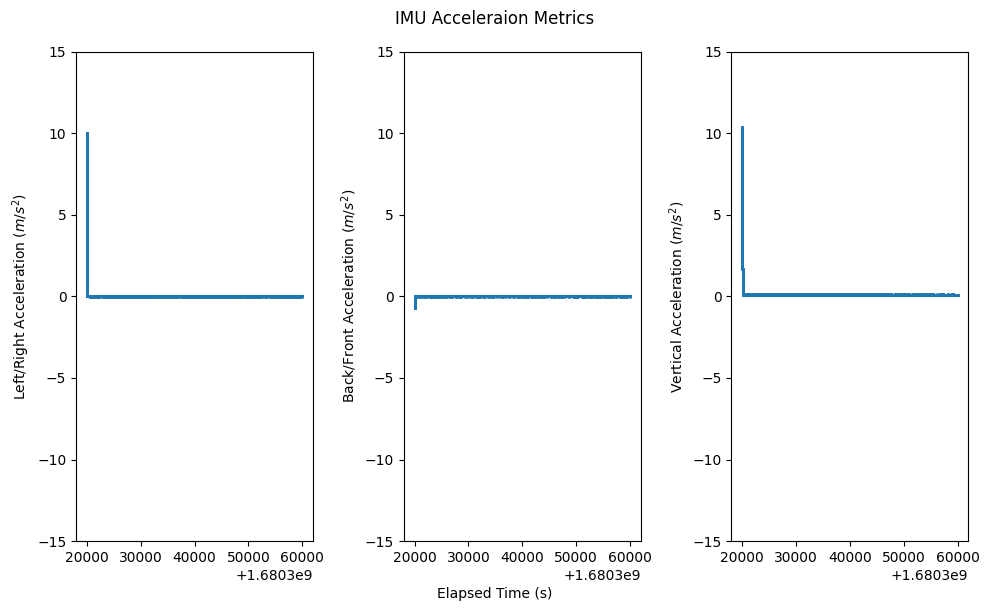

In [117]:
# plot data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(10,6)

ax1.scatter(x=corrected_acc_df['timestamp(epoch in sec)'], y=corrected_acc_df['lr_acc(m/s^2)'], s=1, label='IMU')
ax1.set_ylim(-15,15)

ax2.scatter(x=corrected_acc_df['timestamp(epoch in sec)'], y=corrected_acc_df['bf_acc(m/s^2)'], s=1, label='IMU')
ax2.set_ylim(-15,15)

ax3.scatter(x=corrected_acc_df['timestamp(epoch in sec)'], y=corrected_acc_df['vert_acc(m/s^2)'], s=1, label='IMU')
ax3.set_ylim(-15,15)

fig.suptitle("IMU Acceleraion Metrics")
fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

plt.tight_layout()
plt.show()